## Proximity Learning with CatBoost

This Python code trains a **CatBoost regression model** and computes **instance similarity** based on **proximity learning**. The similarity between two instances is determined by how frequently they appear in the same **leaf node** across trees, with an additional weight based on **tree importance**.

---

## Similarity Computation

We use **Equation (2)** and **Equation (3)** to compute instance similarity.

### Equation (2): Instance Similarity Score

$$
P(i,j) = \frac{1}{N} \sum_{t=1}^{N} \Delta_t \cdot I_t(v(j) = v(i))
$$

where:
- \( N \) is the **total number of trees**.
- \( I_t(v(j) = v(i)) \) is **1 if two instances share a leaf** in tree \( t \), otherwise **0**.
- \( \Delta_t \) is the **importance of tree** \( t \), computed as:

### Equation (3): Tree Importance

$$
\Delta_t = \frac{E(t) - E(t-1)}{\sum_{t=1}^{N} (E(t) - E(t-1))}
$$

where:
- \( E(t) \) is the **error of the model** after tree \( t \).
- The difference \( E(t) - E(t-1) \) measures the **impact of tree \( t \) in reducing error**.

---

## Intuition

- **Instance similarity** is based on **how often instances appear in the same leaf** across trees.
- Trees with **higher importance** (greater error reduction) **contribute more** to the similarity score.
- This approach captures **local relationships** rather than relying on global distance metrics.

This method enhances **interpretability** and **clustering** in machine learning models by leveraging the structure of **gradient boosting decision trees** (GBDTs) like CatBoost.

---

### Notes:
1. Ensure you run this Markdown cell in a **Jupyter Notebook or Jupyter Lab** with MathJax enabled.
2. The equations should now render properly inside Jupyter.




In [2]:
!pip install pandoc

## Step 1: Import Necessary Libraries

In [4]:
import numpy as np
import catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


## Step 2: Load and Process Data from AdBench

In [6]:

# List of datasets to use
datasets = ['2_annthyroid', '5_campaign', '39_vertebral']

def load_dataset(dataset):
    path = f'/Users/langatkipkemoivincent/Desktop/ssalad/jupyter/data/{dataset}.npz'
    data = np.load(path, allow_pickle=True)
    return data['X'], data['y']


## Step 3: Define Function to Train CatBoost and Compute Similarity

In [8]:
def compute_similarity(X, y):
    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a CatBoost Regressor
    model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)
    model.fit(X_train, y_train)
    
    # Get leaf indices for each instance
    leaf_indices_train = model.calc_leaf_indexes(X_train)
    
    # Compute errors for tree importance
    train_preds = model.predict(X_train)
    errors = np.square(train_preds - y_train)  # Squared error per instance
    
    tree_errors = [
    mean_squared_error(y_train, np.array(list(model.staged_predict(X_train, ntree_end=i))[-1]))
    for i in range(1, model.tree_count_ + 1)]

    tree_errors = np.array(tree_errors)
    
    # Compute tree importance
    delta_t = np.diff(tree_errors, prepend=0)
    delta_t /= np.sum(delta_t)
    
    # Compute similarity scores
    num_trees = model.tree_count_
    similarity_matrix = np.zeros((len(X_train), len(X_train)))
    
    for t in range(num_trees):
        leaf_assignments = leaf_indices_train[:, t]
        for i in range(len(X_train)):
            for j in range(len(X_train)):
                if leaf_assignments[i] == leaf_assignments[j]:
                    similarity_matrix[i, j] += delta_t[t]
    
    similarity_matrix /= num_trees
    return similarity_matrix, model


## Step 4: Train Model and Compute Similarity for Each Dataset

In [36]:
results = {}
for dataset in datasets:
    print(f'Processing {dataset}...')
    X, y = load_dataset(dataset)
    
    # Sub-sample 1000 instances (or full dataset if smaller)
    sample_size = min(100, len(X))  # Ensure we don't exceed dataset size
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample, y_sample = X[indices], y[indices]
    
    # Compute similarity
    similarity_matrix, model = compute_similarity(X_sample, y_sample)
    results[dataset] = {'similarity_matrix': similarity_matrix, 'model': model}

Processing 2_annthyroid...
Processing 5_campaign...
Processing 39_vertebral...


## Step 5: Plot Similarity Heatmap

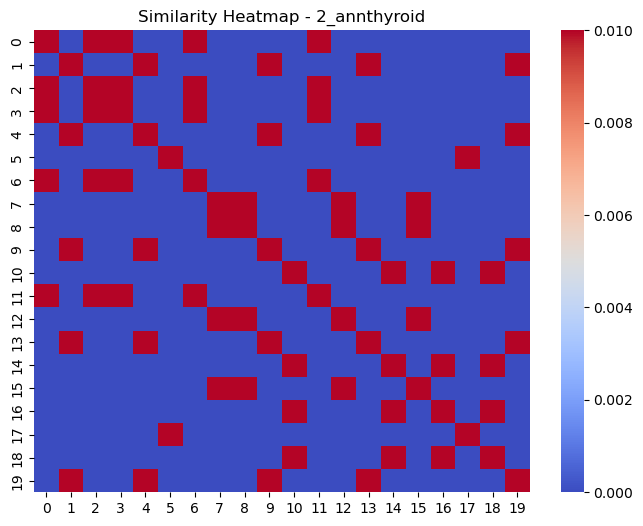

In [38]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix[:20, :20], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['2_annthyroid']['similarity_matrix'], '2_annthyroid')

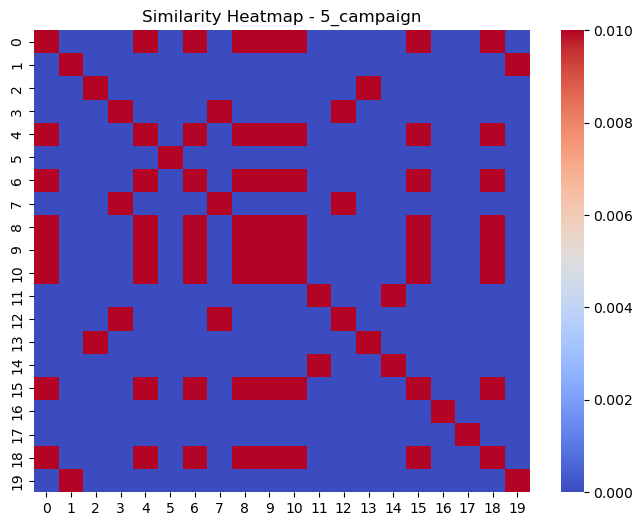

In [39]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix[:20, :20], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['5_campaign']['similarity_matrix'], '5_campaign')

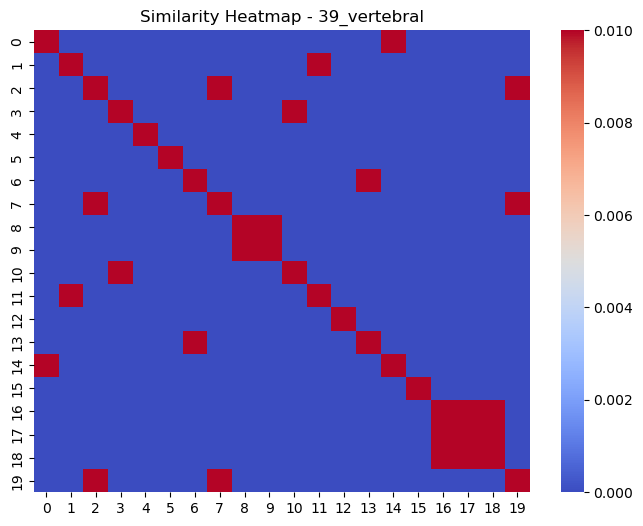

In [40]:
def plot_similarity(similarity_matrix, dataset_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix[:20, :20], cmap='coolwarm', annot=False)
    plt.title(f'Similarity Heatmap - {dataset_name}')
    plt.show()

# Plot for one dataset as an example
plot_similarity(results['39_vertebral']['similarity_matrix'], '39_vertebral')

In [41]:
import pandas as pd

def display_similarity_dataframe(dataset_name):
    """
    Display the similarity matrix as a pandas DataFrame.
    """
    if dataset_name not in results:
        print(f"Dataset '{dataset_name}' not found in results.")
        return
    
    similarity_matrix = results[dataset_name]['similarity_matrix']
    
    # Convert NumPy array to Pandas DataFrame
    similarity_df = pd.DataFrame(similarity_matrix)

    print(f"Similarity DataFrame for {dataset_name}:")
    display(similarity_df.iloc[:10, :10])  # Show the first 10 rows and columns

# Example: Display similarity DataFrame for '2_annthyroid'
display_similarity_dataframe('2_annthyroid')


Similarity DataFrame for 2_annthyroid:


,0,1,2,3,4,5,6,7,8,9
0,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00
1,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01
2,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00
3,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00
4,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01
5,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
6,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00
9,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01


In [42]:
display_similarity_dataframe('5_campaign')

Similarity DataFrame for 5_campaign:


,0,1,2,3,4,5,6,7,8,9
0,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.01
1,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00
4,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.01
5,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
6,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.01
7,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00
8,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.01
9,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.01,0.01


In [43]:
display_similarity_dataframe('39_vertebral')

Similarity DataFrame for 39_vertebral:


,0,1,2,3,4,5,6,7,8,9
0,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00
3,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
7,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01


## Step 6: Save Model and Results

In [45]:
with open('proximity_learning_catboost.pkl', 'wb') as f:
    pickle.dump(results, f)

## Final Thoughts

This method calculates instance similarity using CatBoost trees, where:

- **More co-occurrences in the same leaf** → Higher similarity.  
- **More important trees contribute more to similarity.**  

### This is useful for:  
✅ **Anomaly detection**  
✅ **Clustering similar data points**  
✅ **Feature engineering for recommendation systems**  
